In [86]:
#install des librairies
!conda install numpy
!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
!conda instal sklearn

'conda' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'conda' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'conda' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [87]:
import torch
import networkx as nx
import matplotlib.colors as mcolors

Avec lien : 


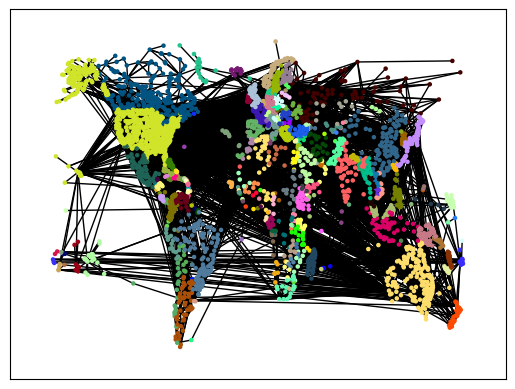

In [88]:
#chargement des données
# Lecture du fichier
G = nx.read_graphml('dataset.graphml')

# Association des couleurs des noeuds en fonction du pays
unique_countries = list(set(G.nodes[node]["country"] for node in G.nodes))
colors_tab = dict(zip(unique_countries,mcolors.get_named_colors_mapping()))
node_colors = [colors_tab[G.nodes[node]["country"]] for node in G.nodes]

# Affichage du graphe avec les noeuds placés à leur position géographique
pos_map = {node: (G.nodes[node]["lon"], G.nodes[node]["lat"]) for node in G.nodes}
print("Avec lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors)

Sans lien : 


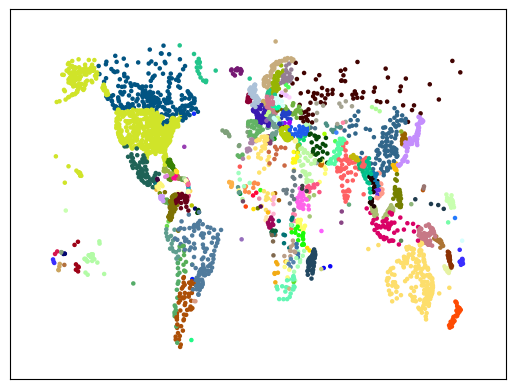

In [89]:
print("Sans lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors, edge_color='none')

 ## Normalization of Data

In [90]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Préparation des données
data = []
for node in G.nodes:
    data.append([G.nodes[node]["city_name"], G.nodes[node]["population"]])
    
df = pd.DataFrame(data, columns=["city_name", "population"])

# Encodage des noms de villes
encoder = OneHotEncoder(sparse_output=False)
city_encoded = encoder.fit_transform(df[['city_name']])

# Normalisation de la population
scaler = MinMaxScaler()
population_normalized = scaler.fit_transform(df[['population']])

# Concaténation des données et conversion en tenseur
processed_data = np.hstack((city_encoded, population_normalized))
processed_data = torch.tensor(processed_data, dtype=torch.float)

# Création d'un mappage des noeuds du graphe
node_map = {node: i for i, node in enumerate(G.nodes)}

# Obtention de l'index des arêtes depuis le graphe G
edges = [(node_map[u], node_map[v]) for u, v in G.edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Création d'un objet Data de PyTorch Geometric et division en train/test
data = Data(x=processed_data, edge_index=edge_index)
train_test = train_test_split_edges(data, test_ratio=0.1, val_ratio=0.2)
print(train_test)

c:\Users\tomhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3363, 3289], val_pos_edge_index=[2, 2709], test_pos_edge_index=[2, 135], train_pos_edge_index=[2, 21406], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 2709], test_neg_edge_index=[2, 135])


In [98]:
hyperParam_grid = {
        'eta': 0.00001,
        'batch_size': 64,
        'nb_epochs': 50,
        'Random_Vect_Dim': 10
    }

## Definition du Générateur

In [99]:
# Définition du générateur

class Generator(nn.Module):
    def __init__(self, latent_dim,output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  
            # 5 dimensions pour les données de noeuds, nom de la ville, pays, population, lat, lon
        )

    def forward(self, z):
        return self.model(z)

## Definiton du Discriminateur

In [100]:
# Définition du discriminateur
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x)

## Entraînement du modèle

In [101]:
generator = Generator(hyperParam_grid.get('Random_Vect_Dim'),5)
# 5 dimensions de sortie pour les données de noeuds, nom de la ville, pays, population, lat, lon
discriminator = Discriminator(5)
# 5 dimensions d'entrée pour les données de noeuds, nom de la ville, pays, population, lat, lon

# Optimiseurs
g_optimizer = optim.Adam(generator.parameters(), lr=hyperParam_grid.get('eta'))
d_optimizer = optim.Adam(discriminator.parameters(), lr=hyperParam_grid.get('eta'))

# Fonction de perte
loss_fn = nn.BCEWithLogitsLoss()

# Entraînement
num_epochs = hyperParam_grid.get('nb_epochs')

for epoch in range(num_epochs):
    # Entraînement du Discriminateur
    d_optimizer.zero_grad()
    
    # Vraies données (train edges)
    node_indices = train_test.train_pos_edge_index[0]  # Récupérer les indices des nœuds
    real_data = train_test.x[node_indices][:, :5]  # Obtenir les caractéristiques des nœuds
    
    real_labels = torch.ones(real_data.size(0), 1)  # Étiquettes pour vraies données
    output_real = discriminator(real_data)  # Passer les vraies données au discriminateur
    loss_real = loss_fn(output_real, real_labels)

    # Fausse données générées par le générateur
    z = torch.randn(real_data.size(0), hyperParam_grid.get('Random_Vect_Dim'))  # Bruit
    fake_data = generator(z)  # Génération de données fictives
    fake_labels = torch.zeros(fake_data.size(0), 1)
    output_fake = discriminator(fake_data)  # Évaluation des données fictives
    loss_fake = loss_fn(output_fake, fake_labels)
    
    loss_D = loss_real + loss_fake
    loss_D.backward()
    d_optimizer.step()
    
    # Entraînement du Générateur
    g_optimizer.zero_grad()
    
    z = torch.randn(real_data.size(0), hyperParam_grid.get('Random_Vect_Dim'))
    fake_data = generator(z)
    output = discriminator(fake_data)  # Évaluation des données générées
    
    # On veut tromper le discriminateur
    loss_G = loss_fn(output, real_labels)  # Utiliser real_labels pour tromper le discriminateur
    loss_G.backward()
    g_optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

Epoch 1/50, Loss D: 1.3905816078186035, Loss G: 0.6597186326980591
Epoch 2/50, Loss D: 1.3905682563781738, Loss G: 0.6598041653633118
Epoch 3/50, Loss D: 1.3904681205749512, Loss G: 0.6598348021507263
Epoch 4/50, Loss D: 1.390472412109375, Loss G: 0.6599161028862
Epoch 5/50, Loss D: 1.3904401063919067, Loss G: 0.6599557995796204
Epoch 6/50, Loss D: 1.3903818130493164, Loss G: 0.6600163578987122
Epoch 7/50, Loss D: 1.3903708457946777, Loss G: 0.6600592732429504
Epoch 8/50, Loss D: 1.390336513519287, Loss G: 0.6601230502128601
Epoch 9/50, Loss D: 1.3902873992919922, Loss G: 0.6601978540420532
Epoch 10/50, Loss D: 1.3903014659881592, Loss G: 0.6602623462677002
Epoch 11/50, Loss D: 1.3902170658111572, Loss G: 0.6602944135665894
Epoch 12/50, Loss D: 1.3902145624160767, Loss G: 0.6603406071662903
Epoch 13/50, Loss D: 1.3901256322860718, Loss G: 0.6604089736938477
Epoch 14/50, Loss D: 1.3901289701461792, Loss G: 0.6604565382003784
Epoch 15/50, Loss D: 1.390087366104126, Loss G: 0.660541951656

In [102]:
# Évaluation sur les arêtes de validation
generator.eval()
discriminator.eval()

with torch.no_grad():
    # Générer des échantillons de bruit pour le générateur
    z = torch.randn(train_test.x.size(0), hyperParam_grid.get('Random_Vect_Dim'))
    generated_data = generator(z)  # Passer uniquement z au générateur

    # Obtenir les scores du discriminateur pour les données générées et réelles
    output_generated = discriminator(generated_data)  # Passer uniquement les données générées
    node_indices = train_test.train_pos_edge_index[0]  # Récupérer les indices des nœuds
    real_data = train_test.x[node_indices][:, :5]  # Obtenir les caractéristiques des nœuds   
    output_real = discriminator(real_data)  # Passer uniquement les vraies données
    
    # Appliquer la fonction sigmoid pour obtenir des probabilités
    output_real = torch.sigmoid(output_real)
    output_generated = torch.sigmoid(output_generated)

    # Création des étiquettes
    labels_generated = torch.zeros(output_generated.size(0))
    labels_real = torch.ones(output_real.size(0))

    # Concaténer les sorties et les labels
    outputs = torch.cat((output_real, output_generated), dim=0)
    labels = torch.cat((labels_real, labels_generated), dim=0)


# Calculer l'exactitude
predicted = (outputs > 0.5).float()  # Prédictions binaires
predicted = predicted.squeeze() 
accuracy = (predicted == labels).sum().item() / labels.size(0)
print(f'Accuracy : {accuracy * 100:.2f}%')

# Calculer l'AUC
auc = roc_auc_score(labels.numpy(), outputs.numpy())
print(f'AUC : {auc:.4f}')


Accuracy : 86.42%
AUC : 0.2283
